# SVR on 5JUN2023 data

In [116]:
%load_ext autoreload
%autoreload 2

In [114]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [145]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap

## load data

In [108]:
df = pd.read_csv("../data/5JUN2023_Provisional_endo_study_data_to_test_AI.csv").fillna(0)
df.Sex = np.where(df.Sex == "male", 0, 1)
# df.Sex = df.Sex.astype('category')
df.head()

,Sex,A_EPM_distance,A_EPM_pct_open_arms,A_Open_field_distance,A_LOF_pct_center,RP_Withdrawal_latency,OR_lick_time,OR_num_lick_bursts,OR__Lick_burst_length,FSA_Consumption_time,DSA_1st_week_infusions,OPAD_37oC__lick_face,OPAD_46_5oC_lick_face,RP_Delta_hargreaves
0,0,1272.67,31.58,5128.37,12.46,14.48,97.350,69.25,1.372342,66.45,86.0,10.25,1.50,0.06
1,0,1272.52,18.75,5037.27,10.68,14.84,85.125,105.00,1.444197,75.28,87.0,24.75,5.50,0.17
2,0,1462.30,29.03,5340.03,19.06,11.68,205.375,112.75,1.459464,64.88,120.0,15.00,5.00,-1.38
3,0,1288.02,20.59,5384.21,5.36,12.69,185.550,71.75,1.312209,29.45,94.0,15.75,4.25,-0.41
4,0,880.52,4.35,3919.19,1.65,17.56,239.200,136.75,1.912567,61.02,108.0,18.75,5.00,2.49


## scale data

In [109]:
# determine which cols to standardize
z_cols = [
    "A_EPM_distance", 
    "A_EPM_pct_open_arms", 
    "A_Open_field_distance", 
    "A_LOF_pct_center", 
    "RP_Withdrawal_latency", 
    "OR_lick_time", 
    "OR_num_lick_bursts", 
    "OR__Lick_burst_length", 
    "FSA_Consumption_time", 
    "OPAD_37oC__lick_face", 
    "OPAD_46_5oC_lick_face", 
    "RP_Delta_hargreaves",
    "DSA_1st_week_infusions"
]
df[z_cols] = StandardScaler().fit_transform(df[z_cols]) # scale data (z scores)

In [110]:
df.head()

,Sex,A_EPM_distance,A_EPM_pct_open_arms,A_Open_field_distance,A_LOF_pct_center,RP_Withdrawal_latency,OR_lick_time,OR_num_lick_bursts,OR__Lick_burst_length,FSA_Consumption_time,DSA_1st_week_infusions,OPAD_37oC__lick_face,OPAD_46_5oC_lick_face,RP_Delta_hargreaves
0,0,-0.018964,0.733076,-0.131135,1.036909,0.201703,-1.263194,-0.717777,-0.528817,0.536718,-0.034145,-0.925942,-2.686533,-0.328085
1,0,-0.019549,-0.266963,-0.236146,0.667732,0.412481,-1.548823,0.864985,-0.081422,1.027931,-0.016174,1.571948,0.561995,-0.196131
2,0,0.720971,0.534316,0.112846,2.405766,-1.437681,1.260741,1.208102,0.013638,0.449379,0.576878,-0.107668,0.155929,-2.055477
3,0,0.040932,-0.123543,0.163772,-0.435649,-0.846332,0.797542,-0.607095,-0.903226,-1.521592,0.109625,0.021534,-0.453170,-0.891886
4,0,-1.549130,-1.389376,-1.524957,-1.205112,2.005024,2.051040,2.270655,2.834815,0.234647,0.361223,0.538338,0.155929,2.586891


## split features (X) / target (y)

In [111]:
X, y = df.drop('DSA_1st_week_infusions', axis=1), df.DSA_1st_week_infusions

## find best params

In [117]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

In [124]:
grid_search = GridSearchCV(SVR(),param_grid,refit=True, scoring='neg_mean_absolute_error', cv=10)

In [125]:
grid_search.fit(X, y)
grid_search.best_params_

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

## run model

In [126]:
params = grid_search.best_params_
model = SVR(**params)

In [129]:
model.fit(X, y)
y_pred = model.predict(X)

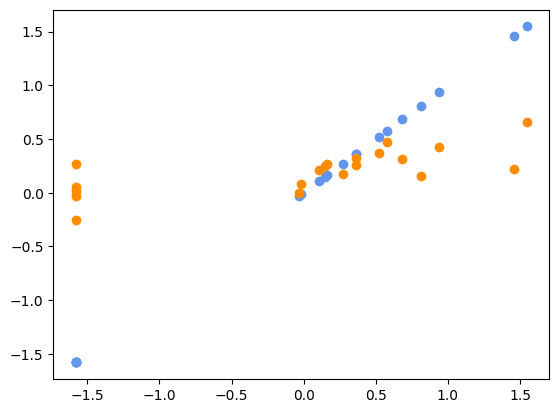

In [143]:
plt.scatter(y, y, color='cornflowerblue')
plt.scatter(y, y_pred, color='darkorange')
plt.show()

In [148]:
mse, mae, r2 = (
    mean_squared_error(y, y_pred), 
    mean_absolute_error(y, y_pred), 
    r2_score(y, y_pred)
)
pd.DataFrame(columns=['error'], index=['mean_squared_error', 'mean_absolute_error', 'r2_score'], data=[mse, mae, r2])

,error
mean_squared_error,0.801929
mean_absolute_error,0.626461
r2_score,0.198071


## SHAP values
Interesting ... the SVR ranks the variable importance differently that XGBoostRegressor. However, `A_EPM_distance` is chosen has having the most influence in the dependence plots.

* KernelExplainer reference: https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a

In [158]:
# need to change int and bool to classes int_ and bool_ to handle error 'numpy' has no attribute 'int'/'bool'/etc.
np.bool = np.bool_
np.int = np.int_
np.float = np.float_

explainer = shap.KernelExplainer(model.predict, data=X)
shap_values = explainer.shap_values(X)

  0%|          | 0/20 [00:00<?, ?it/s]

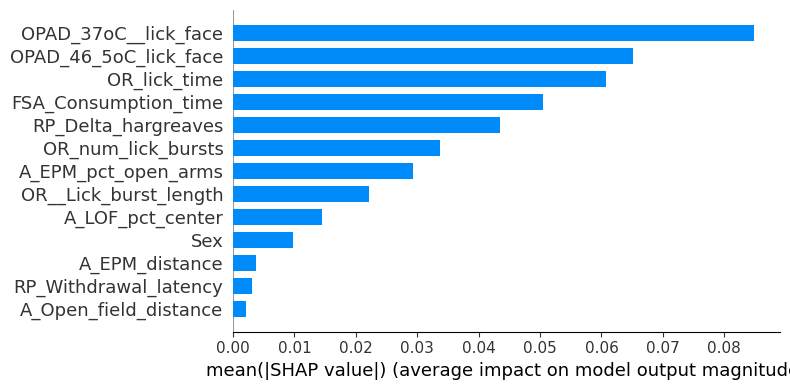

In [164]:
# shap.plots.bar(shap_values) # I don't know why this doesn't work
# shap.plots.bar(shap_values.cohorts(2).abs.mean(0))
shap.summary_plot(shap_values, X, plot_type='bar', plot_size=(8, 4))

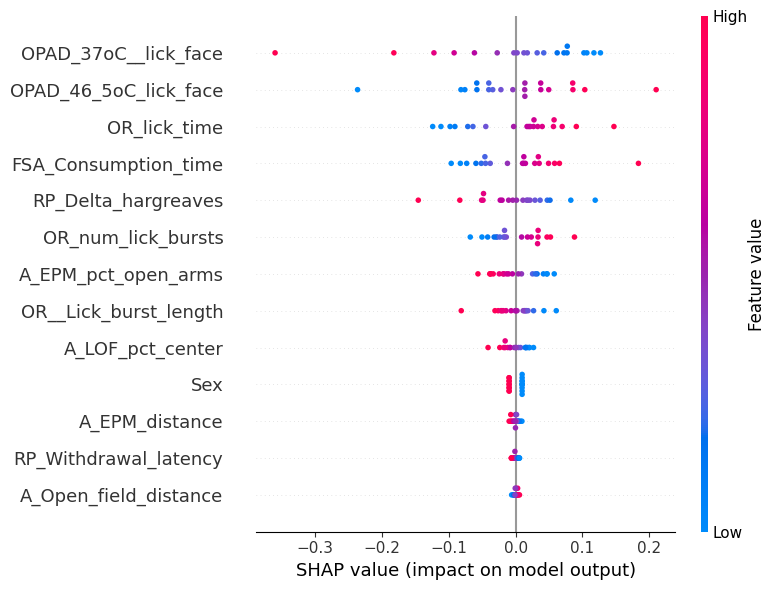

In [161]:
shap.summary_plot(shap_values, X, plot_size=(8, 6))

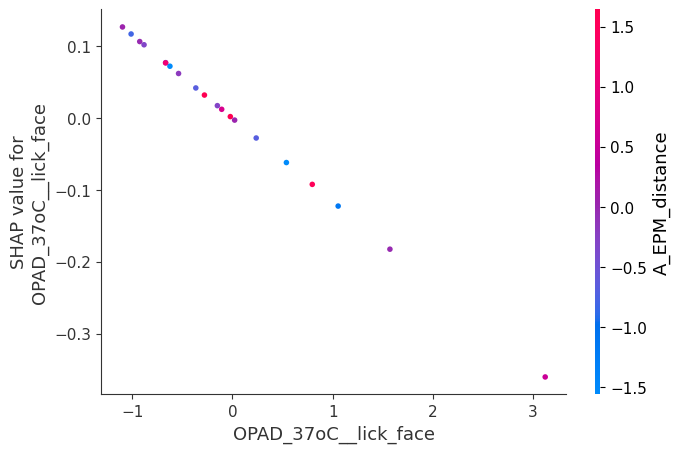

In [168]:
shap.dependence_plot("OPAD_37oC__lick_face", shap_values, X)

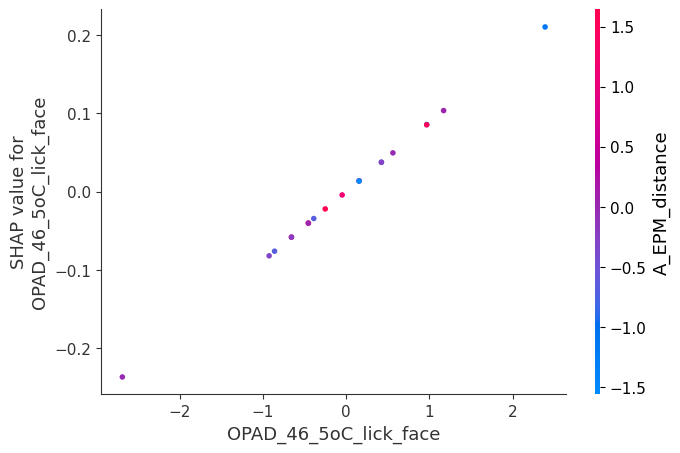

In [166]:
shap.dependence_plot("OPAD_46_5oC_lick_face", shap_values, X)

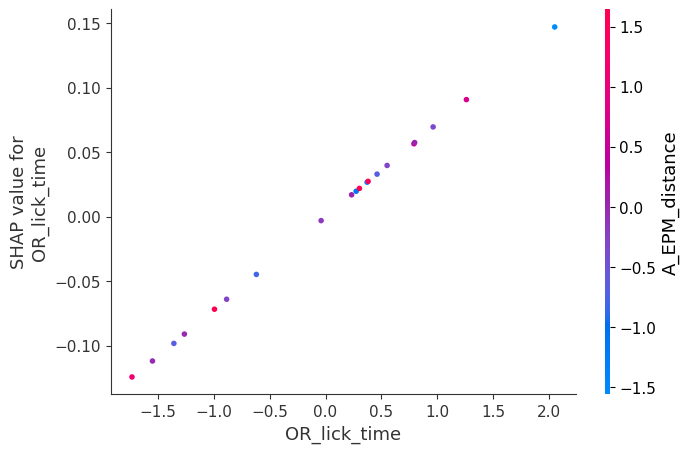

In [169]:
shap.dependence_plot("OR_lick_time", shap_values, X)

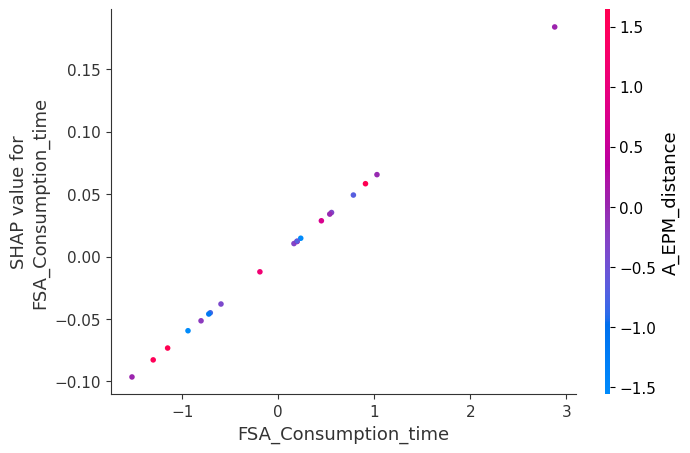

In [171]:
shap.dependence_plot("FSA_Consumption_time", shap_values, X)

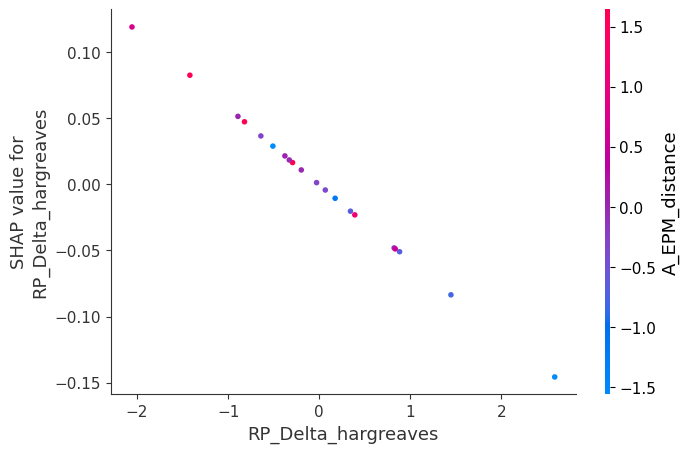

In [172]:
shap.dependence_plot("RP_Delta_hargreaves", shap_values, X)

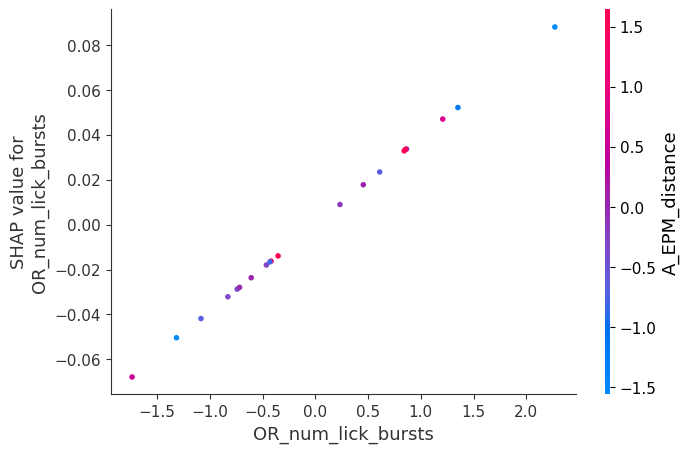

In [173]:
shap.dependence_plot("OR_num_lick_bursts", shap_values, X)